In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from torch.utils.data import DataLoader
from steams.data import KVyQVx
from steams.models.attention import madsnn4
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))


In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [40]:
#model
model = madsnn4(device,type="krig",kernel="exp", input_k=2,input_q=2, input_v=1, hidden_size=32)

In [41]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [42]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=20,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train    valid
0     0  1.007777  1.00505
  epoch     train     valid
0     1  1.003181  1.000324
  epoch     train     valid
0     2  1.005403  1.000089
  epoch     train    valid
0     3  0.997274  0.98899
  epoch     train     valid
0     4  0.980385  0.970949
  epoch     train     valid
0     5  0.940307  0.918787
  epoch     train     valid
0     6  0.877105  0.832271
  epoch     train     valid
0     7  0.776702  0.710463
  epoch     train     valid
0     8  0.656624  0.585306
  epoch     train     valid
0     9  0.549675  0.482525
  epoch     train     valid
0    10  0.480367  0.418572
  epoch     train     valid
0    11  0.435847  0.377441
  epoch     train     valid
0    12  0.414666  0.348272
  epoch     train     valid
0    13  0.392742  0.320202
  epoch     train     valid
0    14  0.381901  0.310589
  epoch     train     valid
0    15  0.370037  0.290147
  epoch     train     valid
0    16  0.362376  0.283874
  epoch    train     valid
0    17  7.15324  0.29739

In [15]:
obj.save_model(resdir,"1c-nwdnn4")

## Or load model

In [16]:
obj.load_model(resdir,"1c-nwdnn4")

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


## Evaluation

In [17]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [18]:
criterion = R2()
obj.init_criterion(criterion)

In [19]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.8898283950984478


In [20]:
criterion = RMSE()
obj.init_criterion(criterion)

In [21]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

35.47746396064758


In [22]:
criterion = variance()
obj.init_criterion(criterion)

In [23]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

686.8567237854004


## QQplot

In [24]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [25]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


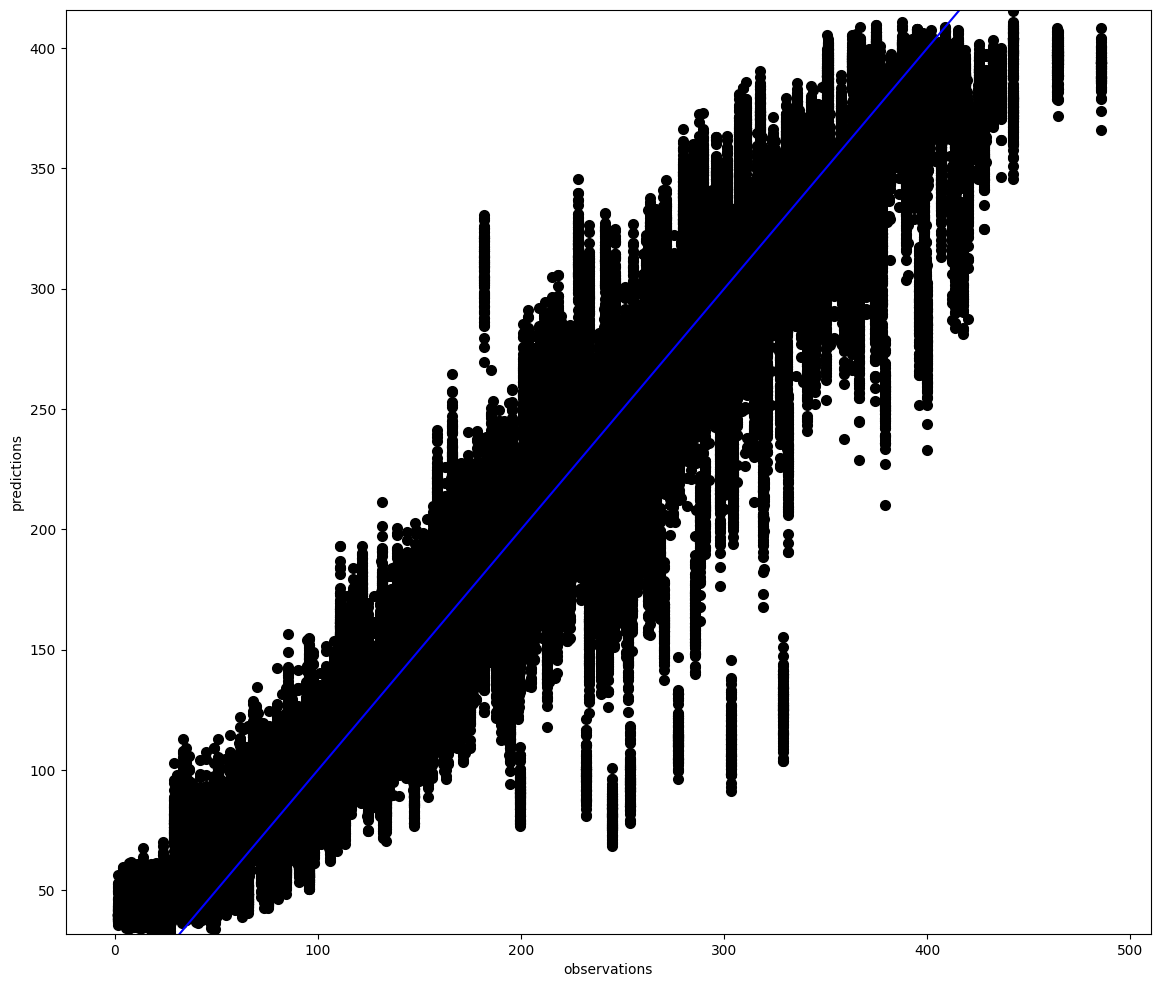

In [26]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
# ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1c-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of a 2d-map prediction

In [27]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["ref"],
          "nb_location" : 6400,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 6400
        }
    }

In [28]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")

eval_dataset = KVyQVx(params)

In [29]:
eval_dataset.scale(True)
KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[0]
QUERY_res, VALUE_res = obj.predict(KEY_Y,VALUE_Y,QUERY_X,eval_dataset)

In [30]:
# output
VALUE_X = torch.reshape(VALUE_X,(1,VALUE_X.shape[0],VALUE_X.shape[1]))
#QUERY_X_unscale = eval_dataset.unscale(QUERY_X,"QUERY").to(device)
VALUE_X_unscale = eval_dataset.unscale(VALUE_X,"VALUE_X").to(device)

In [31]:
tmp = np.concatenate((QUERY_res, VALUE_res,VALUE_X_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
results = pd.DataFrame(tmp,columns=['x','y','values','truth'])   

In [32]:
# predictors
VALUE_Y = torch.reshape(VALUE_Y,(1,VALUE_Y.shape[0],VALUE_Y.shape[1]))
KEY_Y = torch.reshape(KEY_Y,(1,KEY_Y.shape[0],KEY_Y.shape[1]))
KEY_Y_unscale = eval_dataset.unscale(KEY_Y,"KEY").to(device)
VALUE_Y_unscale = eval_dataset.unscale(VALUE_Y,"VALUE_Y").to(device)

tmp = np.concatenate((KEY_Y_unscale, VALUE_Y_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
predictors = pd.DataFrame(tmp,columns=['x','y','values'])        

In [33]:
vmax = np.array(
    results['values'].max(),
    results['truth'].max()).max()

vmin = np.array(
    results['values'].min(),
    results['truth'].min()).min()

In [34]:
foo = predictors.copy()
# unique_rmse = np.unique(foo["rmse"])
# unique_variance = np.unique(foo["variance"])
# symbol_rmse = [i for i in range(1,len(unique_rmse)+1)]
# symbol_variance = ['o','v','s','p','s','D']#[i for i in range(len(unique_variance))]


In [35]:
results

,x,y,values,truth
0,4345787.5,4092387.5,96.823532,78.395256
1,4343337.5,4086887.5,316.624115,284.943878
2,4351012.5,4092312.5,176.810104,190.192322
3,4349012.5,4089262.5,63.266266,49.678421
4,4345562.5,4089587.5,197.667053,172.275131
...,...,...,...,...
6395,4351362.5,4097062.5,395.445679,386.755432
6396,4353137.5,4093612.5,129.644257,101.117653
6397,4355237.5,4096662.5,169.369308,177.168213
6398,4342587.5,4098012.5,298.395355,263.356720


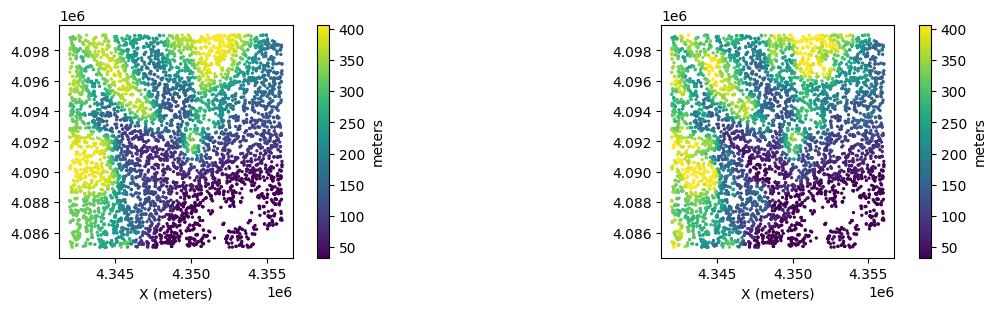

In [36]:
fig = plt.figure(constrained_layout=True,figsize=(12, 3))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], s=2,c=results['values'],vmin=vmin,vmax=vmax)
#ax1.set(ylabel='Y (meters)')
ax1.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

ax2 = fig.add_subplot(gs[0,1])
c2 = ax2.scatter(x=results["x"], y=results["y"], s=2,c=results['truth'],vmin=vmin,vmax=vmax)
#ax2.set(ylabel='Y (meters)')
ax2.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

fig.colorbar(c1, ax=ax1,label ='meters')
fig.colorbar(c2, ax=ax2,label ='meters')

fig_filename = os.path.join(parent_dir,'fig','illustration_prediction.png')
plt.savefig(fig_filename, dpi = 300)
